In [ ]:
import os
import sys
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.io as sio
import anndata as ad
import matplotlib.pyplot as plt

os.chdir("/data/wuqinhua/scPhase/AD")

# 1. Cell-level

In [ ]:
adata = sc.read_h5ad("./ensemble_adata_with_attention.h5ad")
adata

AnnData object with n_obs × n_vars = 1378211 × 5000
    obs: 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference', 'Class', 'celltype', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'phenotype', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'sample_id', 'donor_id', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'suspension_type', 'development_stage_ontology_term_id', 'Continuous Pseudo-progression Score', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'attention_weight_mean', 'attention_weight_std'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_

In [ ]:
metadata = adata.obs
metadata.to_csv("./AD_metadata.csv")

In [ ]:
idList = adata.obs['sample_id'].unique()
for id in idList:
    attnTmp = adata.obs[adata.obs['sample_id'] == id]
    avgScore = 1 / len(attnTmp)
    log_attn = np.log2(attnTmp['attention_weight_mean'] / avgScore)
    attn_scaled = (log_attn - np.mean(log_attn)) / np.std(log_attn)
    attn_scaled_clipped = np.clip(attn_scaled, -1, 1)
    adata.obs.loc[adata.obs['sample_id'] == id, 'attn_scaled'] = attn_scaled_clipped

In [ ]:
adata1 = adata[adata.obs['phenotype'] == "Not AD"]
adata2 = adata[adata.obs['phenotype'] == "Low"]
adata3 = adata[adata.obs['phenotype'] == "Intermediate"]
adata4 = adata[adata.obs['phenotype'] == "High"]    


In [ ]:
sc.settings.verbosity = 1
sc.settings.figdir = '/data/wuqinhua/scPhase/AD/Analysis/Figure/Attn_plot'
sc.settings.set_figure_params(dpi=100, fontsize=10, dpi_save=400,
    facecolor = 'white', figsize=(6,6), format='png')
def one_col_lgd(umap,ncol):
    legend = umap.legend(bbox_to_anchor=[1.00, 0.5],
    loc='center left', ncol=ncol, prop={'size': 6})
    legend.get_frame().set_linewidth(0.0)
    return legend

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


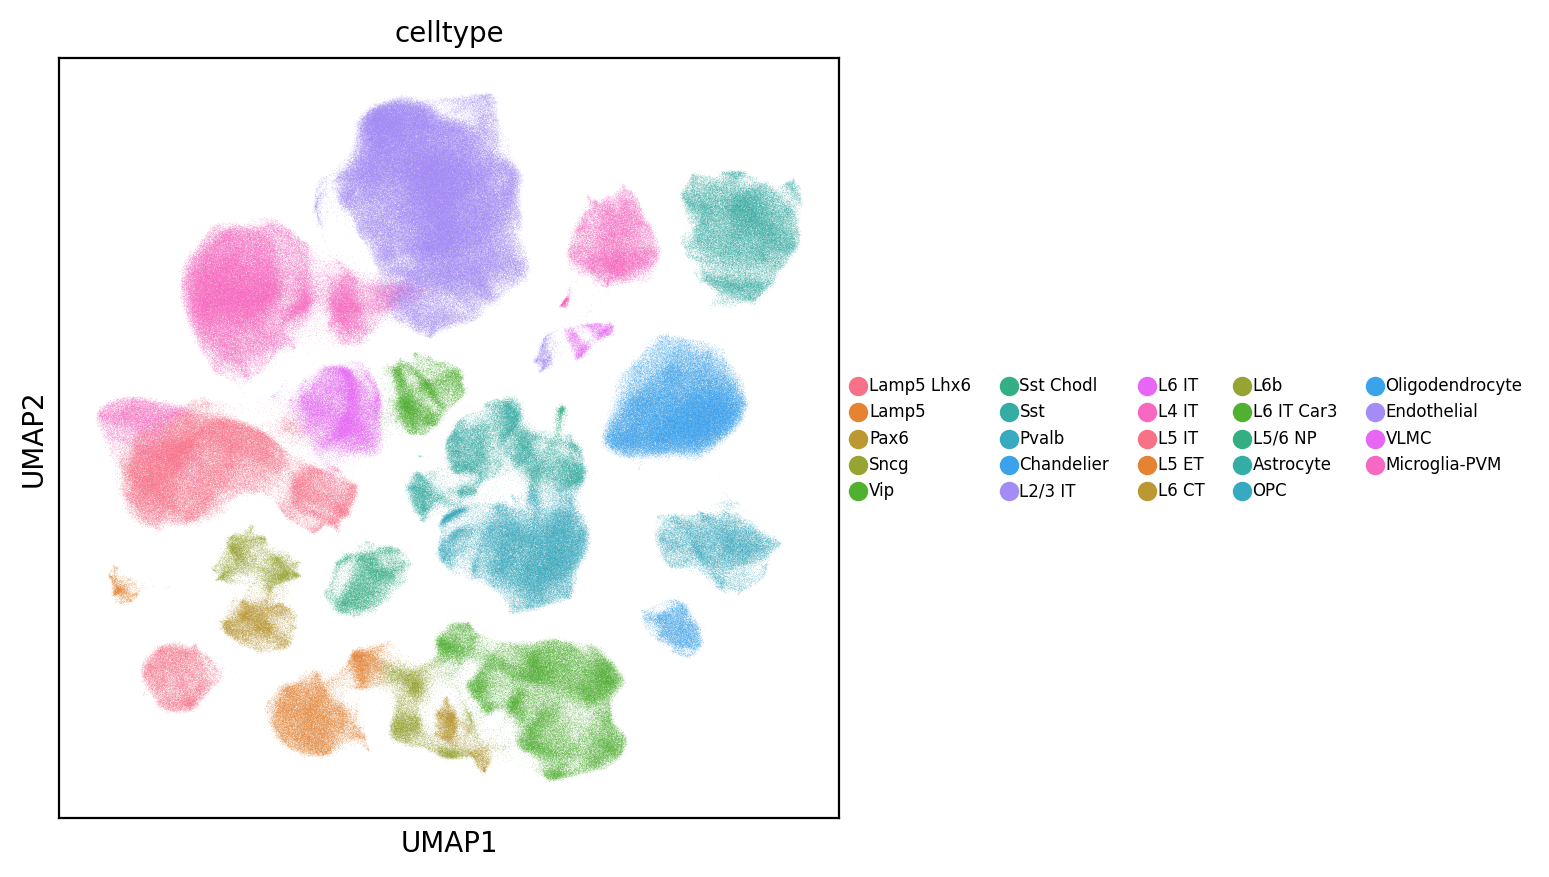

In [ ]:
leiden_umap = sc.pl.umap(adata, color=['celltype'],
    show=False, palette=sns.color_palette("husl", 12),
legend_fontsize=6, frameon=True, title='celltype')
lgd = one_col_lgd(leiden_umap,5)
fig = leiden_umap.get_figure()
fig.set_size_inches(5, 5)
fig.savefig(str(sc.settings.figdir) + '/umap_celltype.pdf', 
            format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


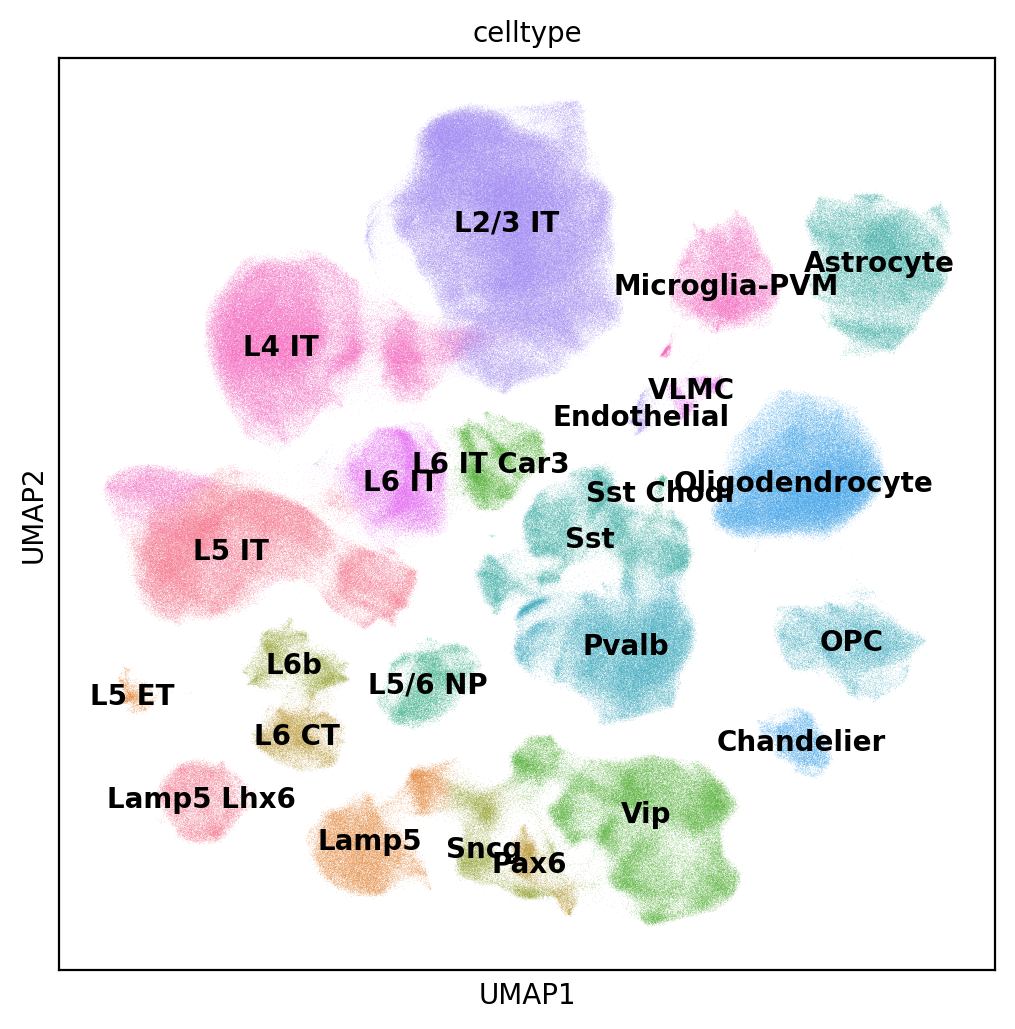

In [ ]:
sc.pl.umap(adata, color=['celltype'], legend_loc="on data")

/home/wuqinhua/anaconda3/envs/phase/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


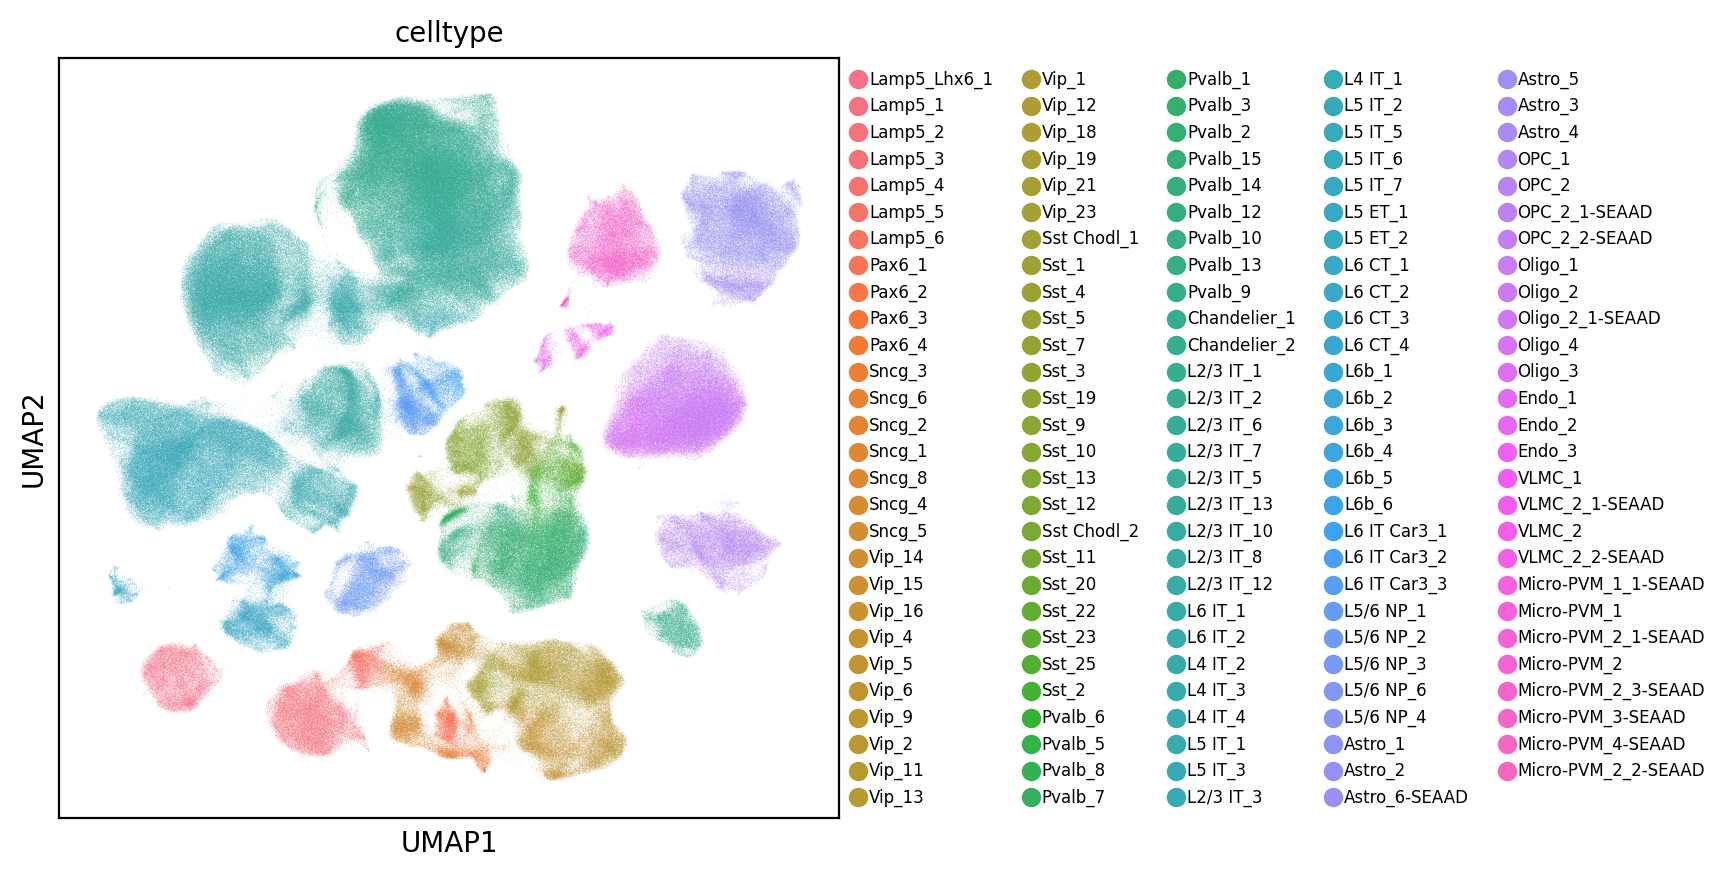

In [ ]:
leiden_umap = sc.pl.umap(adata, color=['Supertype'],
    show=False, palette=sns.color_palette("husl", 150),
legend_fontsize=6, frameon=True, title='celltype')
lgd = one_col_lgd(leiden_umap,5)
fig = leiden_umap.get_figure()
fig.set_size_inches(5, 5)
fig.savefig(str(sc.settings.figdir) + '/umap_Supertype.pdf', 
            format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
leiden_umap = sc.pl.umap(adata1, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of normal',save="_attn_normal.pdf")

In [ ]:
leiden_umap = sc.pl.umap(adata2, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of Low',save="_attn_Low.pdf")

In [ ]:
leiden_umap = sc.pl.umap(adata3, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of Intermediate',save="_attn_Intermediate.pdf")


In [ ]:
leiden_umap = sc.pl.umap(adata4, color='attn_scaled', show=False, legend_fontsize=6, color_map ='viridis',
                           frameon= True, title='Attention Score of High',save="_attn_High.pdf")


# 2. Celltype-level

In [1]:
setwd('/data/wuqinhua/scPhase/AD')
# rm(list = ls())
# gc()

library(tidyr)
library(ggplot2)
library(forestploter)
library(gridExtra)
library(tidyverse)
library(dplyr)
library(broom)
library(ggpubr)
library(randomForest)
library(mice)
library(reshape2)
library(Metrics)
library(ComplexHeatmap)
library(RColorBrewer)
library(fastcluster)
library(ggbeeswarm)
library(circlize)
library(ggrepel)
library(ggpubr)
library(scales) 
library(ggtext)
library(lme4)
library(lmerTest)
library(ordinal)  

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:gridExtra’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:bas

### 2.1 Scatter trend plot

In [2]:
attnData = read.csv('./AD_metadata.csv')
head(attnData)
colnames(attnData)

nameAll = unique(attnData$celltype)
nameAll = sort(nameAll)
nameAll

nameList = nameAll


sampleFold = data.frame(id = character(), celltype = character(), fold = numeric())
idList = unique(attnData$sample_id)
for (id in idList) {
  attnTmp = attnData %>% filter(sample_id == id)
  avgScore = 1 / dim(attnTmp)[1]
  foldRes = attnTmp %>% group_by(celltype) %>% summarise(res = median(log2(attention_weight_mean/avgScore)))
  dataTmp = data.frame(id = rep(id,dim(foldRes)[1]),
                       celltype = foldRes$celltype,
                       fold = foldRes$res)
  dataTmp_s = dataTmp %>% filter(celltype %in% nameList)
  
  dataTmp_s$fold = scale(dataTmp_s$fold)
  sampleFold = rbind(sampleFold,dataTmp_s)
}

sampleFold.Table = dcast(sampleFold,id ~ celltype)
rownames(sampleFold.Table) = sampleFold.Table$id
sampleFold.Table$id = NULL

sampleInfo = read.csv('/data/wuqinhua/scPhase/AD/sample_info.csv')
rownames(sampleInfo) = sampleInfo$sample_id
sampleInfo = sampleInfo[rownames(sampleFold.Table),]
head(sampleFold.Table)

,exp_component_name,assay_ontology_term_id,cell_type_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,tissue_ontology_term_id,is_primary_data,Neurotypical.reference,Class,⋯,cell_type,assay,disease,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,attention_weight_mean,attention_weight_std
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,GGTGATTAGGTCACTT-L8TX_210722_01_H06-1153814299,EFO:0009922,CL:0000128,PATO:0000461,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Non-neuronal and Non-neural,⋯,oligodendrocyte,10x 3' v3,normal,female,middle temporal gyrus,European,85-year-old stage,T=H$Plq&E2,2.065857e-05,3.228923e-05
2,TTGAACGCAGGTGTGA-L8TX_210729_01_G12-1153814338,EFO:0009922,CL:4023040,PATO:0000461,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,L2/3-6 intratelencephalic projecting glutamatergic neuron,10x 3' v3,normal,female,middle temporal gyrus,European,80 year-old and over stage,y{tFR9vo#0,7.072472e-06,6.566316e-06
3,GGGAGTAAGGCATTTC-L8TX_210107_01_H09-1142430361,EFO:0009922,CL:4023040,PATO:0000461,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,L2/3-6 intratelencephalic projecting glutamatergic neuron,10x 3' v3,normal,female,middle temporal gyrus,European,82-year-old stage,zH(x0YMZ<{,6.980327e-05,4.708810e-05
4,ACAGAAAGTATCGTGT-L8TX_210415_01_G01-1153814188,EFO:0009922,CL:4023012,PATO:0000461,HANCESTRO:0005,PATO:0000384,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,near-projecting glutamatergic cortical neuron,10x 3' v3,normal,male,middle temporal gyrus,European,80 year-old and over stage,p7~=!!bMo0,1.097759e-04,1.160562e-04
5,TTGTTCAAGCGAGAAA-L8TX_210513_01_F11-1153814259,EFO:0009922,CL:0000128,MONDO:0001627,HANCESTRO:0005,PATO:0000384,UBERON:0002771,True,False,Non-neuronal and Non-neural,⋯,oligodendrocyte,10x 3' v3,dementia,male,middle temporal gyrus,European,68-year-old stage,l-<b+c~q($,1.471677e-03,2.910000e-03
6,TTTATGCCAGCCCAGT-L8TX_210826_01_C06-1153814371,EFO:0009922,CL:4023040,MONDO:0001627,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,L2/3-6 intratelencephalic projecting glutamatergic neuron,10x 3' v3,dementia,female,middle temporal gyrus,European,80 year-old and over stage,%c}jnC9>G),4.461655e-05,6.690527e-05


[1] "exp_component_name"                      
 [2] "assay_ontology_term_id"                  
 [3] "cell_type_ontology_term_id"              
 [4] "disease_ontology_term_id"                
 [5] "self_reported_ethnicity_ontology_term_id"
 [6] "sex_ontology_term_id"                    
 [7] "tissue_ontology_term_id"                 
 [8] "is_primary_data"                         
 [9] "Neurotypical.reference"                  
[10] "Class"                                   
[11] "celltype"                                
[12] "Supertype"                               
[13] "Age.at.death"                            
[14] "Years.of.education"                      
[15] "Cognitive.status"                        
[16] "phenotype"                               
[17] "Braak.stage"                             
[18] "Thal.phase"                              
[19] "CERAD.score"                             
[20] "APOE4.status"                            
[21] "Lewy.body.disease.pathology"             
[22] "LATE.NC.stage"                           
[23] "Microinfarct.pathology"                  
[24] "sample_id"                               
[25] "donor_id"                                
[26] "PMI"                                     
[27] "Number.of.UMIs"                          
[28] "Genes.detected"                          
[29] "Fraction.mitochrondrial.UMIs"            
[30] "suspension_type"                         
[31] "development_stage_ontology_term_id"      
[32] "Continuous.Pseudo.progression.Score"     
[33] "tissue_type"                             
[34] "cell_type"                               
[35] "assay"                                   
[36] "disease"                                 
[37] "sex"                                     
[38] "tissue"                                  
[39] "self_reported_ethnicity"                 
[40] "development_stage"                       
[41] "observation_joinid"                      
[42] "attention_weight_mean"                   
[43] "attention_weight_std"

[1] "Astrocyte"       "Chandelier"      "Endothelial"     "L2/3 IT"        
 [5] "L4 IT"           "L5 ET"           "L5 IT"           "L5/6 NP"        
 [9] "L6 CT"           "L6 IT"           "L6 IT Car3"      "L6b"            
[13] "Lamp5"           "Lamp5 Lhx6"      "Microglia-PVM"   "Oligodendrocyte"
[17] "OPC"             "Pax6"            "Pvalb"           "Sncg"           
[21] "Sst"             "Sst Chodl"       "Vip"             "VLMC"

Using fold as value column: use value.var to override.



,Astrocyte,Chandelier,Endothelial,L2/3 IT,L4 IT,L5 ET,L5 IT,L5/6 NP,L6 CT,L6 IT,⋯,Microglia-PVM,Oligodendrocyte,OPC,Pax6,Pvalb,Sncg,Sst,Sst Chodl,Vip,VLMC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M1TX_190626_107_A01_A01,-0.8276110,-0.7263933,-1.109881,1.999373,1.007065,1.8156649,1.914467,0.6978794,0.05087183,0.9488251,⋯,-1.251171,-0.5982416,-1.340063,-0.8515275,0.002516452,-0.6665790,-0.14602858,0.49322020,-0.3868529,-0.58176749
M1TX_190626_107_B01_B01,-0.7470894,-0.4986723,-1.347321,2.010406,1.103476,1.6916148,2.012675,0.7869463,0.06232625,1.1132235,⋯,-1.204687,-0.7002407,-1.193100,-0.8283652,-0.014252729,-0.6994707,-0.16318009,-0.24013604,-0.3976184,-0.03450846
M1TX_190626_107_C01_C01,-0.8647136,-0.5757887,-1.087178,2.048574,1.055787,1.2401693,2.012296,0.6809458,-0.07555687,1.1554777,⋯,-1.284124,-0.7149443,-1.295006,-0.9641248,-0.058038909,-0.6544783,-0.17224748,0.12344132,-0.3602006,NA
M1TX_190626_107_D01_D01,-0.6603021,-0.5252973,-1.305205,1.984187,1.099255,1.4221094,1.971188,0.7376670,0.30782981,1.1181874,⋯,-1.261403,-0.6626199,-1.173744,-0.6228790,0.054901431,-0.6656942,-0.10425417,0.05994286,-0.3538870,-1.32918549
M1TX_190626_107_E01_E01,-0.6879726,-0.5195926,-1.252485,1.978007,1.040398,1.8495107,1.916731,0.7008121,0.29678385,0.9226110,⋯,-1.453905,-0.5698089,-1.137000,-0.6515122,0.059090007,-0.6747384,-0.07852019,-0.12707058,-0.3073699,-1.04792366
M1TX_190822_101_D01,NA,-0.4421787,-1.128788,1.771019,0.749948,0.6969132,1.476608,0.1156645,1.08358150,1.3107957,⋯,-1.339248,-1.1122298,-1.445052,-0.9596498,-0.072696740,NA,-0.13294142,-0.15806106,-0.4953865,NA


In [3]:
# ===================================================================
# 1. Calculation Score 1: Association with Categorical Phenotypes (Linear Mixed-Effects Model)
# ===================================================================

modeling_data <- merge(sampleFold.Table, sampleInfo, by.x = "row.names", by.y = "sample_id")

rownames(modeling_data) <- modeling_data$Row.names
modeling_data$Row.names <- NULL

modeling_data$phenotype <- as.factor(modeling_data$phenotype)

phenotype_association_scores_lmm <- data.frame(
  cell_type = character(),
  p_value = numeric()
)

for (cell in colnames(sampleFold.Table)) {

  formula <- as.formula(paste0("`", cell, "` ~ phenotype + (1 | donor_id)"))

  model_fit <- try(lmer(formula, data = modeling_data))

  if (inherits(model_fit, "try-error")) {
    p_val <- NA
  } else {
    model_summary <- summary(model_fit)
    p_val <- anova(model_fit)$`Pr(>F)`[1] 
  }
  
  phenotype_association_scores_lmm <- rbind(
    phenotype_association_scores_lmm,
    data.frame(
      cell_type = cell,
      p_value = p_val
    )
  )
}

phenotype_association_scores_lmm <- phenotype_association_scores_lmm %>%
  mutate(neg_log10_pval = -log10(p_value))

head(phenotype_association_scores_lmm)

# ===================================================================
# 2. Calculation Score 2: Population Volatility (standard deviation considering donor effect)
# ===================================================================
long_format_data <- sampleFold.Table %>%
  rownames_to_column(var = "sample_id") %>%
  pivot_longer(
    cols = -sample_id,
    names_to = "cell_type",
    values_to = "score"
  ) %>%
  left_join(sampleInfo %>% select(sample_id, donor_id), by = "sample_id")

head(long_format_data)

donor_variation_scores <- data.frame(
  cell_type = character(),
  donor_effect_sd = numeric())

for (cell in colnames(sampleFold.Table)) {

  subset_data <- long_format_data %>%
    filter(cell_type == cell) %>%
    na.omit()

  model_fit <- try(lmer(score ~ (1 | donor_id), data = subset_data))
  
  sd_val <- NA 
  
  if (!inherits(model_fit, "try-error")) {
    var_corr <- as.data.frame(VarCorr(model_fit))
    sd_val <- var_corr[var_corr$grp == "donor_id", "sdcor"]
  }
  
  donor_variation_scores <- rbind(
    donor_variation_scores,
    data.frame(
      cell_type = cell,
      donor_effect_sd = sd_val
    )
  )
}

head(donor_variation_scores)

,cell_type,p_value,neg_log10_pval
,<chr>,<dbl>,<dbl>
1,Astrocyte,5.318278e-12,11.2742290
2,Chandelier,1.344649e-01,0.8713911
3,Endothelial,1.994474e-02,1.7001715
4,L2/3 IT,4.842668e-10,9.3149153
5,L4 IT,3.583067e-06,5.4457451
6,L5 ET,6.105550e-03,2.2142752


sample_id,cell_type,score,donor_id
<chr>,<chr>,<dbl>,<chr>
M1TX_190626_107_A01_A01,Astrocyte,-0.8276110,H18.30.002
M1TX_190626_107_A01_A01,Chandelier,-0.7263933,H18.30.002
M1TX_190626_107_A01_A01,Endothelial,-1.1098811,H18.30.002
M1TX_190626_107_A01_A01,L2/3 IT,1.9993731,H18.30.002
M1TX_190626_107_A01_A01,L4 IT,1.0070650,H18.30.002
M1TX_190626_107_A01_A01,L5 ET,1.8156649,H18.30.002


,cell_type,donor_effect_sd
,<chr>,<dbl>
1,Astrocyte,1.3634803
2,Chandelier,0.2446339
3,Endothelial,0.4406809
4,L2/3 IT,0.8405241
5,L4 IT,0.5564972
6,L5 ET,0.4310991


,cell_type,p_value,neg_log10_pval,donor_effect_sd,scaled_pval,scaled_sd,keyness_score,label_text
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Astrocyte,5.318278e-12,11.2742290,1.3634803,1.00000000,1.00000000,1.000000000,Astrocyte
2,Chandelier,1.344649e-01,0.8713911,0.2446339,0.03964118,0.09460852,0.003750394,
3,Endothelial,1.994474e-02,1.7001715,0.4406809,0.11615171,0.25325342,0.029415817,
4,L2/3 IT,4.842668e-10,9.3149153,0.8405241,0.81912203,0.57681402,0.472481070,L2/3 IT
5,L4 IT,3.583067e-06,5.4457451,0.5564972,0.46193183,0.34697417,0.160278416,L4 IT
6,L5 ET,6.105550e-03,2.2142752,0.4310991,0.16361222,0.24549965,0.040166743,


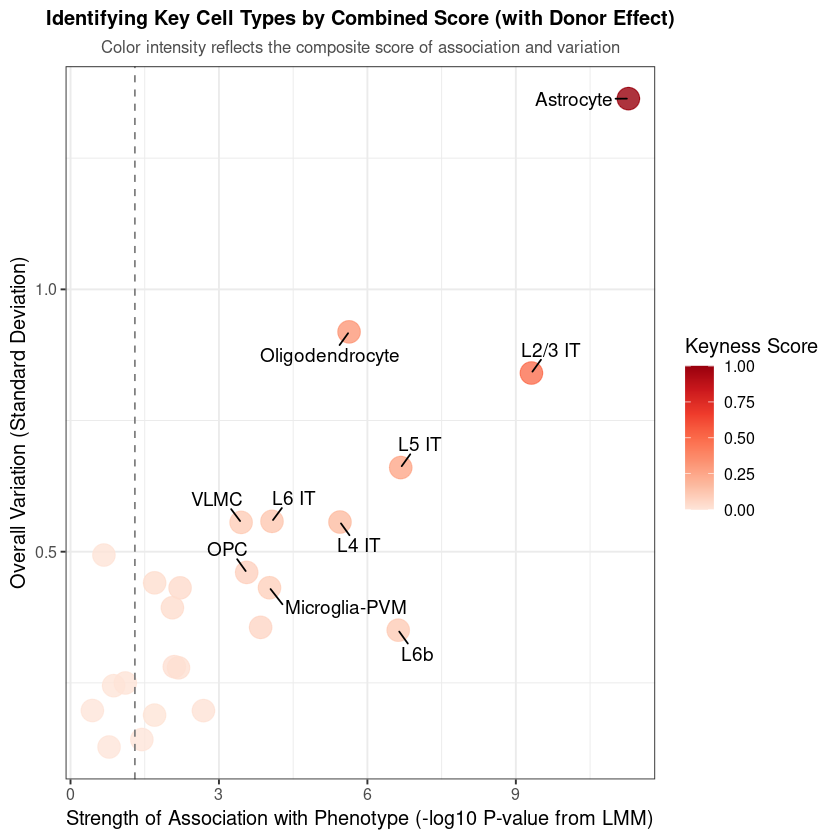

In [4]:
# ===================================================================
# 3. Integrate the scores and create "key scores" for coloring
# ===================================================================
plot_data_combined_score <- merge(
  phenotype_association_scores_lmm, 
  donor_variation_scores, 
  by = "cell_type"
) %>%
  mutate(
    scaled_pval = rescale(neg_log10_pval, to = c(0, 1)),
    scaled_sd = rescale(donor_effect_sd, to = c(0, 1)),
    keyness_score = scaled_pval * scaled_sd,
    label_text = ifelse(keyness_score > quantile(keyness_score, 0.6, na.rm = TRUE), cell_type, "")
  )

head(plot_data_combined_score)

# ===================================================================
# 4. Plot
# ===================================================================
combined_score_plot <- ggplot(plot_data_combined_score, 
                              aes(x = neg_log10_pval, 
                                  y = donor_effect_sd, 
                                  color = keyness_score, 
                                  label = label_text)) +
  geom_point(size = 6, alpha = 0.8) +
  scale_color_distiller(palette = "Reds", direction = 1, name = "Keyness Score") +
  geom_text_repel(color = "black", size = 4, max.overlaps = Inf,
                  box.padding = 0.6, min.segment.length = 0) +
  geom_vline(xintercept = -log10(0.05), linetype = "dashed", color = "gray50") +
  theme_bw(base_size = 12) +
  labs(
    title = "Identifying Key Cell Types by Combined Score (with Donor Effect)",
    subtitle = "Color intensity reflects the composite score of association and variation",
    x = "Strength of Association with Phenotype (-log10 P-value from LMM)",
    y = "Overall Variation (Standard Deviation)"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
    plot.subtitle = element_text(hjust = 0.5, size = 10, color = "gray30"),
    legend.position = "right"
  )

ggsave("./Analysis/Figure/Attn_plot/classification_combined_score_plot_with_donor_effect.pdf", 
       combined_score_plot, 
       width = 8, height = 5, dpi = 300)

print(combined_score_plot)

### 2.2 Violin Plot

,exp_component_name,assay_ontology_term_id,cell_type_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,tissue_ontology_term_id,is_primary_data,Neurotypical.reference,Class,⋯,cell_type,assay,disease,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,attention_weight_mean,attention_weight_std
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,GGTGATTAGGTCACTT-L8TX_210722_01_H06-1153814299,EFO:0009922,CL:0000128,PATO:0000461,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Non-neuronal and Non-neural,⋯,oligodendrocyte,10x 3' v3,normal,female,middle temporal gyrus,European,85-year-old stage,T=H$Plq&E2,2.065857e-05,3.228923e-05
2,TTGAACGCAGGTGTGA-L8TX_210729_01_G12-1153814338,EFO:0009922,CL:4023040,PATO:0000461,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,L2/3-6 intratelencephalic projecting glutamatergic neuron,10x 3' v3,normal,female,middle temporal gyrus,European,80 year-old and over stage,y{tFR9vo#0,7.072472e-06,6.566316e-06
3,GGGAGTAAGGCATTTC-L8TX_210107_01_H09-1142430361,EFO:0009922,CL:4023040,PATO:0000461,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,L2/3-6 intratelencephalic projecting glutamatergic neuron,10x 3' v3,normal,female,middle temporal gyrus,European,82-year-old stage,zH(x0YMZ<{,6.980327e-05,4.708810e-05
4,ACAGAAAGTATCGTGT-L8TX_210415_01_G01-1153814188,EFO:0009922,CL:4023012,PATO:0000461,HANCESTRO:0005,PATO:0000384,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,near-projecting glutamatergic cortical neuron,10x 3' v3,normal,male,middle temporal gyrus,European,80 year-old and over stage,p7~=!!bMo0,1.097759e-04,1.160562e-04
5,TTGTTCAAGCGAGAAA-L8TX_210513_01_F11-1153814259,EFO:0009922,CL:0000128,MONDO:0001627,HANCESTRO:0005,PATO:0000384,UBERON:0002771,True,False,Non-neuronal and Non-neural,⋯,oligodendrocyte,10x 3' v3,dementia,male,middle temporal gyrus,European,68-year-old stage,l-<b+c~q($,1.471677e-03,2.910000e-03
6,TTTATGCCAGCCCAGT-L8TX_210826_01_C06-1153814371,EFO:0009922,CL:4023040,MONDO:0001627,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,L2/3-6 intratelencephalic projecting glutamatergic neuron,10x 3' v3,dementia,female,middle temporal gyrus,European,80 year-old and over stage,%c}jnC9>G),4.461655e-05,6.690527e-05


[1] "exp_component_name"                      
 [2] "assay_ontology_term_id"                  
 [3] "cell_type_ontology_term_id"              
 [4] "disease_ontology_term_id"                
 [5] "self_reported_ethnicity_ontology_term_id"
 [6] "sex_ontology_term_id"                    
 [7] "tissue_ontology_term_id"                 
 [8] "is_primary_data"                         
 [9] "Neurotypical.reference"                  
[10] "Class"                                   
[11] "celltype"                                
[12] "Supertype"                               
[13] "Age.at.death"                            
[14] "Years.of.education"                      
[15] "Cognitive.status"                        
[16] "phenotype"                               
[17] "Braak.stage"                             
[18] "Thal.phase"                              
[19] "CERAD.score"                             
[20] "APOE4.status"                            
[21] "Lewy.body.disease.pathology"             
[22] "LATE.NC.stage"                           
[23] "Microinfarct.pathology"                  
[24] "sample_id"                               
[25] "donor_id"                                
[26] "PMI"                                     
[27] "Number.of.UMIs"                          
[28] "Genes.detected"                          
[29] "Fraction.mitochrondrial.UMIs"            
[30] "suspension_type"                         
[31] "development_stage_ontology_term_id"      
[32] "Continuous.Pseudo.progression.Score"     
[33] "tissue_type"                             
[34] "cell_type"                               
[35] "assay"                                   
[36] "disease"                                 
[37] "sex"                                     
[38] "tissue"                                  
[39] "self_reported_ethnicity"                 
[40] "development_stage"                       
[41] "observation_joinid"                      
[42] "attention_weight_mean"                   
[43] "attention_weight_std"

[1] "Astro_1"             "Astro_2"             "Astro_3"            
  [4] "Astro_4"             "Astro_5"             "Astro_6-SEAAD"      
  [7] "Chandelier_1"        "Chandelier_2"        "Endo_1"             
 [10] "Endo_2"              "Endo_3"              "L2/3 IT_1"          
 [13] "L2/3 IT_10"          "L2/3 IT_12"          "L2/3 IT_13"         
 [16] "L2/3 IT_2"           "L2/3 IT_3"           "L2/3 IT_5"          
 [19] "L2/3 IT_6"           "L2/3 IT_7"           "L2/3 IT_8"          
 [22] "L4 IT_1"             "L4 IT_2"             "L4 IT_3"            
 [25] "L4 IT_4"             "L5 ET_1"             "L5 ET_2"            
 [28] "L5 IT_1"             "L5 IT_2"             "L5 IT_3"            
 [31] "L5 IT_5"             "L5 IT_6"             "L5 IT_7"            
 [34] "L5/6 NP_1"           "L5/6 NP_2"           "L5/6 NP_3"          
 [37] "L5/6 NP_4"           "L5/6 NP_6"           "L6 CT_1"            
 [40] "L6 CT_2"             "L6 CT_3"             "L6 CT_4"            
 [43] "L6 IT Car3_1"        "L6 IT Car3_2"        "L6 IT Car3_3"       
 [46] "L6 IT_1"             "L6 IT_2"             "L6b_1"              
 [49] "L6b_2"               "L6b_3"               "L6b_4"              
 [52] "L6b_5"               "L6b_6"               "Lamp5_1"            
 [55] "Lamp5_2"             "Lamp5_3"             "Lamp5_4"            
 [58] "Lamp5_5"             "Lamp5_6"             "Lamp5_Lhx6_1"       
 [61] "Micro-PVM_1"         "Micro-PVM_1_1-SEAAD" "Micro-PVM_2"        
 [64] "Micro-PVM_2_1-SEAAD" "Micro-PVM_2_2-SEAAD" "Micro-PVM_2_3-SEAAD"
 [67] "Micro-PVM_3-SEAAD"   "Micro-PVM_4-SEAAD"   "Oligo_1"            
 [70] "Oligo_2"             "Oligo_2_1-SEAAD"     "Oligo_3"            
 [73] "Oligo_4"             "OPC_1"               "OPC_2"              
 [76] "OPC_2_1-SEAAD"       "OPC_2_2-SEAAD"       "Pax6_1"             
 [79] "Pax6_2"              "Pax6_3"              "Pax6_4"             
 [82] "Pvalb_1"             "Pvalb_10"            "Pvalb_12"           
 [85] "Pvalb_13"            "Pvalb_14"            "Pvalb_15"           
 [88] "Pvalb_2"             "Pvalb_3"             "Pvalb_5"            
 [91] "Pvalb_6"             "Pvalb_7"             "Pvalb_8"            
 [94] "Pvalb_9"             "Sncg_1"              "Sncg_2"             
 [97] "Sncg_3"              "Sncg_4"              "Sncg_5"             
[100] "Sncg_6"              "Sncg_8"              "Sst Chodl_1"        
[103] "Sst Chodl_2"         "Sst_1"               "Sst_10"             
[106] "Sst_11"              "Sst_12"              "Sst_13"             
[109] "Sst_19"              "Sst_2"               "Sst_20"             
[112] "Sst_22"              "Sst_23"              "Sst_25"             
[115] "Sst_3"               "Sst_4"               "Sst_5"              
[118] "Sst_7"               "Sst_9"               "Vip_1"              
[121] "Vip_11"              "Vip_12"              "Vip_13"             
[124] "Vip_14"              "Vip_15"              "Vip_16"             
[127] "Vip_18"              "Vip_19"              "Vip_2"              
[130] "Vip_21"              "Vip_23"              "Vip_4"              
[133] "Vip_5"               "Vip_6"               "Vip_9"              
[136] "VLMC_1"              "VLMC_2"              "VLMC_2_1-SEAAD"     
[139] "VLMC_2_2-SEAAD"

Using fold as value column: use value.var to override.



,Astro_1,Astro_2,Astro_3,Astro_4,Astro_5,Astro_6-SEAAD,Chandelier_1,Chandelier_2,Endo_1,Endo_2,⋯,Vip_21,Vip_23,Vip_4,Vip_5,Vip_6,Vip_9,VLMC_1,VLMC_2,VLMC_2_1-SEAAD,VLMC_2_2-SEAAD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M1TX_190626_107_A01_A01,-1.1517335,-0.8907732,-0.6304039,-0.1737355,-0.1543579,-1.0250310,-0.4493458,-0.8705907,-1.163321,NA,⋯,-0.34625175,-0.4233674,-0.4318888,-0.9609806,-0.4573042,-0.3224992,-0.6414496,-0.95870185,NA,NA
M1TX_190626_107_B01_B01,-0.8202004,-0.7876454,-0.5318391,-0.6692305,-0.6517811,NA,-0.6179248,-0.4555812,NA,-1.368780,⋯,-0.46525262,-0.4498103,-0.3739924,-0.7086564,-0.6980659,-0.4358381,NA,-0.08168036,NA,NA
M1TX_190626_107_C01_C01,-0.9194964,-0.9689881,-0.8614170,-0.2378349,-0.8743788,-1.0394658,-0.7137495,-0.5577484,-1.180930,-1.088874,⋯,-0.21175078,-0.5111023,-0.4317657,-1.1572610,-0.6245523,-0.5880132,NA,NA,NA,NA
M1TX_190626_107_D01_D01,-0.9437667,-0.8071009,-0.6567774,0.1123785,-0.5992475,NA,-0.5636158,-0.6573477,NA,-1.411805,⋯,-0.90293332,-0.4923185,-0.5421228,-0.7135707,-0.5198857,-0.5263743,-1.0864736,-1.57645845,NA,NA
M1TX_190626_107_E01_E01,-1.0461226,-0.8850144,-0.9306768,-0.1761412,-0.5740323,-0.5017598,-0.6987164,-0.6737665,NA,-1.424657,⋯,-0.33431476,-0.5405147,-0.4558638,-1.3735816,-0.3436508,-0.2456935,-1.2150717,NA,NA,NA
M1TX_190822_101_D01,NA,NA,NA,NA,NA,NA,-0.6693288,-0.5069233,NA,-1.419246,⋯,-0.05431743,-0.6796496,-0.4921914,-0.7867707,-1.5458421,NA,NA,NA,NA,NA


Warning message in tidy.anova(anova(lmer(Attn ~ group + (1 | donor_id), data = .))):
“The following column names in ANOVA output were not recognized or transformed: NumDF, DenDF”
Warning message in tidy.anova(anova(lmer(Attn ~ group + (1 | donor_id), data = .))):
“The following column names in ANOVA output were not recognized or transformed: NumDF, DenDF”
Warning message in tidy.anova(anova(lmer(Attn ~ group + (1 | donor_id), data = .))):
“The following column names in ANOVA output were not recognized or transformed: NumDF, DenDF”
Warning message in tidy.anova(anova(lmer(Attn ~ group + (1 | donor_id), data = .))):
“The following column names in ANOVA output were not recognized or transformed: NumDF, DenDF”
Warning message in tidy.anova(anova(lmer(Attn ~ group + (1 | donor_id), data = .))):
“The following column names in ANOVA output were not recognized or transformed: NumDF, DenDF”
Warning message in tidy.anova(anova(lmer(Attn ~ group + (1 | donor_id), data = .))):
“The following colum

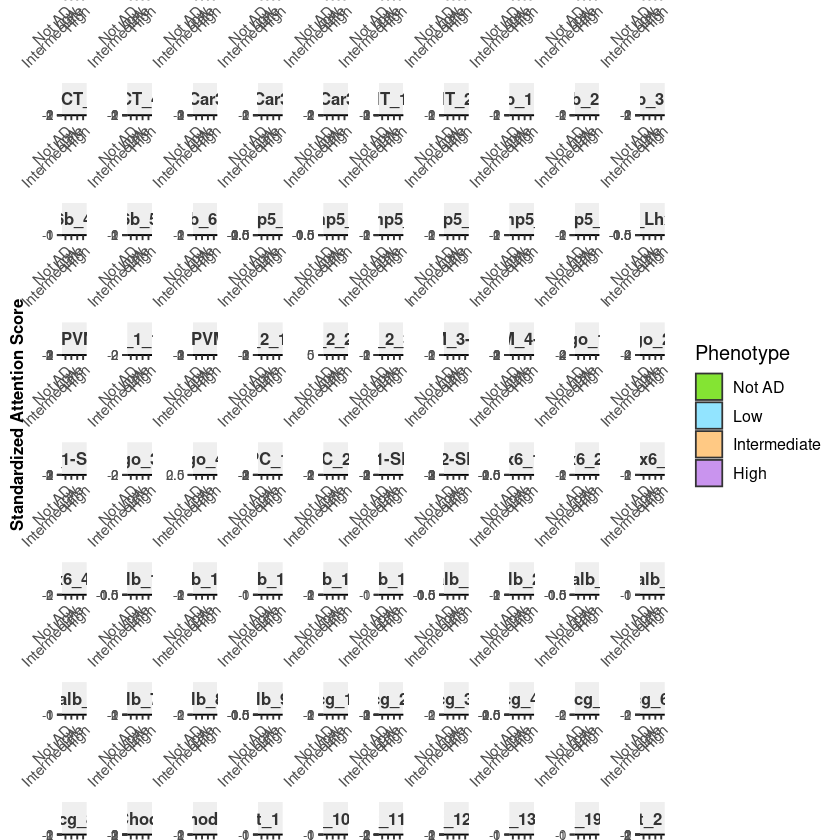

In [5]:
attnData = read.csv('./AD_metadata.csv')
head(attnData)
colnames(attnData)

nameAll = unique(attnData$Supertype)
nameAll = sort(nameAll)
nameAll

nameList = nameAll

sampleFold = data.frame(id = character(), celltype = character(), fold = numeric())
idList = unique(attnData$sample_id)
for (id in idList) {
  attnTmp = attnData %>% filter(sample_id == id)
  avgScore = 1 / dim(attnTmp)[1]
  foldRes = attnTmp %>% group_by(Supertype) %>% summarise(res = median(log2(attention_weight_mean/avgScore)))
  dataTmp = data.frame(id = rep(id,dim(foldRes)[1]),
                       celltype = foldRes$Supertype,
                       fold = foldRes$res)
  dataTmp_s = dataTmp %>% filter(celltype %in% nameList)
  
  dataTmp_s$fold = scale(dataTmp_s$fold)
  sampleFold = rbind(sampleFold,dataTmp_s)
}

sampleFold.Table = dcast(sampleFold,id ~ celltype)
rownames(sampleFold.Table) = sampleFold.Table$id
sampleFold.Table$id = NULL

sampleInfo = read.csv('/data/wuqinhua/scPhase/AD/sample_info.csv')
rownames(sampleInfo) = sampleInfo$sample_id
sampleInfo = sampleInfo[rownames(sampleFold.Table),]
head(sampleFold.Table)

cell_types_attn <- colnames(sampleFold.Table)
combined_data_atten <- data.frame()
for (cell in cell_types_attn) {
  dataTmp <- data.frame(
    atten = sampleFold.Table[[cell]],
    group = sampleInfo$phenotype,
    donor_id = sampleInfo$donor_id,
    cell_type = cell
  )
  dataTmp_s <- na.omit(dataTmp)
  combined_data_atten <- rbind(combined_data_atten, dataTmp_s)
}

custom_colors <- c("Not AD" = '#66DD00',"Low"="#77DDFF","Intermediate"="#FFBB66",'High'='#bb7ae9')

plot_df_attn <- combined_data_atten %>%
  dplyr::rename(Attn = atten) %>%
  dplyr::mutate(group = factor(group, levels = names(custom_colors))) %>%
  na.omit()

annotation_data_lmm <- plot_df_attn %>%
  group_by(cell_type) %>%
  do(broom::tidy(anova(lmer(Attn ~ group + (1 | donor_id), data = .)))) %>%
  ungroup() %>%
  filter(term == "group") %>%
  mutate(
    significance = case_when(
      p.value < 0.001 ~ "***",
      p.value < 0.01  ~ "**",
      p.value < 0.05  ~ "*",
      TRUE ~ "ns"
    ),
    title_with_sig = paste0(cell_type, " ", significance),
    
    stat_label = paste0(
        "F = ", round(statistic, 2),      
        ", ",                             
        scales::pvalue(p.value,           
                       accuracy = 0.001, 
                       add_p = TRUE)
    )
  )

plot_df_attn_final <- plot_df_attn %>%
  left_join(annotation_data_lmm %>% select(cell_type, title_with_sig), by = "cell_type") %>%
  filter(!is.na(title_with_sig))


p_facet_classification_updated <- ggplot(plot_df_attn_final, 
                                         aes(x = group, y = Attn, fill = group)) +
  
  geom_violin(trim = FALSE, alpha = 0.8) +
  geom_boxplot(width = 0.15, fill = "white", alpha = 0.7, outlier.shape = NA) +
  
  geom_text(
    data = annotation_data_lmm, 
    aes(label = stat_label), 
    x = -Inf, y = Inf,
    hjust = -0.1, vjust = 2,
    size = 3.5,
    fontface = "italic",
    inherit.aes = FALSE
  ) + 
  
  scale_fill_manual(values = custom_colors, name = "Phenotype") +

  facet_wrap(~title_with_sig, scales = "free",ncol = 10) +
  
  labs(
    title = "Attention Score Distribution (accounting for Donor Effect)",
    y = "Standardized Attention Score"
  ) +
  
  theme_classic(base_size = 12) +
  theme(
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    strip.background = element_rect(fill = "#EFEFEF", color = NA),
    strip.text = element_text(size = 10, face = "bold", color = "#333333"),
    axis.text.x = element_text(size = 9, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 8),
    axis.title = element_text(size = 10, face = "bold"),
    legend.position = "right",
    axis.title.x = element_blank()
  )

ggsave("./Analysis/Figure/Attn_plot/attn_classification_violin_plot_with_donor_effect_Supertype.pdf",
       p_facet_classification_updated, width = 30, height = 45, dpi = 300)

print(p_facet_classification_updated)

### 2.3 Ordered logistic regression

In [6]:
attnData = read.csv('./AD_metadata.csv')
head(attnData)
colnames(attnData)

nameAll = unique(attnData$Supertype)
nameAll = sort(nameAll)
nameAll

nameList = nameAll

sampleFold = data.frame(id = character(), celltype = character(), fold = numeric())
idList = unique(attnData$sample_id)
for (id in idList) {
  attnTmp = attnData %>% filter(sample_id == id)
  avgScore = 1 / dim(attnTmp)[1]
  foldRes = attnTmp %>% group_by(Supertype) %>% summarise(res = median(log2(attention_weight_mean/avgScore)))
  dataTmp = data.frame(id = rep(id,dim(foldRes)[1]),
                       celltype = foldRes$Supertype,
                       fold = foldRes$res)
  dataTmp_s = dataTmp %>% filter(celltype %in% nameList)
  
  dataTmp_s$fold = scale(dataTmp_s$fold)
  sampleFold = rbind(sampleFold,dataTmp_s)
}

sampleFold.Table = dcast(sampleFold,id ~ celltype)
rownames(sampleFold.Table) = sampleFold.Table$id
sampleFold.Table$id = NULL

sampleInfo = read.csv('/data/wuqinhua/scPhase/AD/sample_info.csv')
rownames(sampleInfo) = sampleInfo$sample_id
sampleInfo = sampleInfo[rownames(sampleFold.Table),]
head(sampleFold.Table)

,exp_component_name,assay_ontology_term_id,cell_type_ontology_term_id,disease_ontology_term_id,self_reported_ethnicity_ontology_term_id,sex_ontology_term_id,tissue_ontology_term_id,is_primary_data,Neurotypical.reference,Class,⋯,cell_type,assay,disease,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,attention_weight_mean,attention_weight_std
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,GGTGATTAGGTCACTT-L8TX_210722_01_H06-1153814299,EFO:0009922,CL:0000128,PATO:0000461,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Non-neuronal and Non-neural,⋯,oligodendrocyte,10x 3' v3,normal,female,middle temporal gyrus,European,85-year-old stage,T=H$Plq&E2,2.065857e-05,3.228923e-05
2,TTGAACGCAGGTGTGA-L8TX_210729_01_G12-1153814338,EFO:0009922,CL:4023040,PATO:0000461,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,L2/3-6 intratelencephalic projecting glutamatergic neuron,10x 3' v3,normal,female,middle temporal gyrus,European,80 year-old and over stage,y{tFR9vo#0,7.072472e-06,6.566316e-06
3,GGGAGTAAGGCATTTC-L8TX_210107_01_H09-1142430361,EFO:0009922,CL:4023040,PATO:0000461,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,L2/3-6 intratelencephalic projecting glutamatergic neuron,10x 3' v3,normal,female,middle temporal gyrus,European,82-year-old stage,zH(x0YMZ<{,6.980327e-05,4.708810e-05
4,ACAGAAAGTATCGTGT-L8TX_210415_01_G01-1153814188,EFO:0009922,CL:4023012,PATO:0000461,HANCESTRO:0005,PATO:0000384,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,near-projecting glutamatergic cortical neuron,10x 3' v3,normal,male,middle temporal gyrus,European,80 year-old and over stage,p7~=!!bMo0,1.097759e-04,1.160562e-04
5,TTGTTCAAGCGAGAAA-L8TX_210513_01_F11-1153814259,EFO:0009922,CL:0000128,MONDO:0001627,HANCESTRO:0005,PATO:0000384,UBERON:0002771,True,False,Non-neuronal and Non-neural,⋯,oligodendrocyte,10x 3' v3,dementia,male,middle temporal gyrus,European,68-year-old stage,l-<b+c~q($,1.471677e-03,2.910000e-03
6,TTTATGCCAGCCCAGT-L8TX_210826_01_C06-1153814371,EFO:0009922,CL:4023040,MONDO:0001627,HANCESTRO:0005,PATO:0000383,UBERON:0002771,True,False,Neuronal: Glutamatergic,⋯,L2/3-6 intratelencephalic projecting glutamatergic neuron,10x 3' v3,dementia,female,middle temporal gyrus,European,80 year-old and over stage,%c}jnC9>G),4.461655e-05,6.690527e-05


[1] "exp_component_name"                      
 [2] "assay_ontology_term_id"                  
 [3] "cell_type_ontology_term_id"              
 [4] "disease_ontology_term_id"                
 [5] "self_reported_ethnicity_ontology_term_id"
 [6] "sex_ontology_term_id"                    
 [7] "tissue_ontology_term_id"                 
 [8] "is_primary_data"                         
 [9] "Neurotypical.reference"                  
[10] "Class"                                   
[11] "celltype"                                
[12] "Supertype"                               
[13] "Age.at.death"                            
[14] "Years.of.education"                      
[15] "Cognitive.status"                        
[16] "phenotype"                               
[17] "Braak.stage"                             
[18] "Thal.phase"                              
[19] "CERAD.score"                             
[20] "APOE4.status"                            
[21] "Lewy.body.disease.pathology"             
[22] "LATE.NC.stage"                           
[23] "Microinfarct.pathology"                  
[24] "sample_id"                               
[25] "donor_id"                                
[26] "PMI"                                     
[27] "Number.of.UMIs"                          
[28] "Genes.detected"                          
[29] "Fraction.mitochrondrial.UMIs"            
[30] "suspension_type"                         
[31] "development_stage_ontology_term_id"      
[32] "Continuous.Pseudo.progression.Score"     
[33] "tissue_type"                             
[34] "cell_type"                               
[35] "assay"                                   
[36] "disease"                                 
[37] "sex"                                     
[38] "tissue"                                  
[39] "self_reported_ethnicity"                 
[40] "development_stage"                       
[41] "observation_joinid"                      
[42] "attention_weight_mean"                   
[43] "attention_weight_std"

[1] "Astro_1"             "Astro_2"             "Astro_3"            
  [4] "Astro_4"             "Astro_5"             "Astro_6-SEAAD"      
  [7] "Chandelier_1"        "Chandelier_2"        "Endo_1"             
 [10] "Endo_2"              "Endo_3"              "L2/3 IT_1"          
 [13] "L2/3 IT_10"          "L2/3 IT_12"          "L2/3 IT_13"         
 [16] "L2/3 IT_2"           "L2/3 IT_3"           "L2/3 IT_5"          
 [19] "L2/3 IT_6"           "L2/3 IT_7"           "L2/3 IT_8"          
 [22] "L4 IT_1"             "L4 IT_2"             "L4 IT_3"            
 [25] "L4 IT_4"             "L5 ET_1"             "L5 ET_2"            
 [28] "L5 IT_1"             "L5 IT_2"             "L5 IT_3"            
 [31] "L5 IT_5"             "L5 IT_6"             "L5 IT_7"            
 [34] "L5/6 NP_1"           "L5/6 NP_2"           "L5/6 NP_3"          
 [37] "L5/6 NP_4"           "L5/6 NP_6"           "L6 CT_1"            
 [40] "L6 CT_2"             "L6 CT_3"             "L6 CT_4"            
 [43] "L6 IT Car3_1"        "L6 IT Car3_2"        "L6 IT Car3_3"       
 [46] "L6 IT_1"             "L6 IT_2"             "L6b_1"              
 [49] "L6b_2"               "L6b_3"               "L6b_4"              
 [52] "L6b_5"               "L6b_6"               "Lamp5_1"            
 [55] "Lamp5_2"             "Lamp5_3"             "Lamp5_4"            
 [58] "Lamp5_5"             "Lamp5_6"             "Lamp5_Lhx6_1"       
 [61] "Micro-PVM_1"         "Micro-PVM_1_1-SEAAD" "Micro-PVM_2"        
 [64] "Micro-PVM_2_1-SEAAD" "Micro-PVM_2_2-SEAAD" "Micro-PVM_2_3-SEAAD"
 [67] "Micro-PVM_3-SEAAD"   "Micro-PVM_4-SEAAD"   "Oligo_1"            
 [70] "Oligo_2"             "Oligo_2_1-SEAAD"     "Oligo_3"            
 [73] "Oligo_4"             "OPC_1"               "OPC_2"              
 [76] "OPC_2_1-SEAAD"       "OPC_2_2-SEAAD"       "Pax6_1"             
 [79] "Pax6_2"              "Pax6_3"              "Pax6_4"             
 [82] "Pvalb_1"             "Pvalb_10"            "Pvalb_12"           
 [85] "Pvalb_13"            "Pvalb_14"            "Pvalb_15"           
 [88] "Pvalb_2"             "Pvalb_3"             "Pvalb_5"            
 [91] "Pvalb_6"             "Pvalb_7"             "Pvalb_8"            
 [94] "Pvalb_9"             "Sncg_1"              "Sncg_2"             
 [97] "Sncg_3"              "Sncg_4"              "Sncg_5"             
[100] "Sncg_6"              "Sncg_8"              "Sst Chodl_1"        
[103] "Sst Chodl_2"         "Sst_1"               "Sst_10"             
[106] "Sst_11"              "Sst_12"              "Sst_13"             
[109] "Sst_19"              "Sst_2"               "Sst_20"             
[112] "Sst_22"              "Sst_23"              "Sst_25"             
[115] "Sst_3"               "Sst_4"               "Sst_5"              
[118] "Sst_7"               "Sst_9"               "Vip_1"              
[121] "Vip_11"              "Vip_12"              "Vip_13"             
[124] "Vip_14"              "Vip_15"              "Vip_16"             
[127] "Vip_18"              "Vip_19"              "Vip_2"              
[130] "Vip_21"              "Vip_23"              "Vip_4"              
[133] "Vip_5"               "Vip_6"               "Vip_9"              
[136] "VLMC_1"              "VLMC_2"              "VLMC_2_1-SEAAD"     
[139] "VLMC_2_2-SEAAD"

Using fold as value column: use value.var to override.



,Astro_1,Astro_2,Astro_3,Astro_4,Astro_5,Astro_6-SEAAD,Chandelier_1,Chandelier_2,Endo_1,Endo_2,⋯,Vip_21,Vip_23,Vip_4,Vip_5,Vip_6,Vip_9,VLMC_1,VLMC_2,VLMC_2_1-SEAAD,VLMC_2_2-SEAAD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M1TX_190626_107_A01_A01,-1.1517335,-0.8907732,-0.6304039,-0.1737355,-0.1543579,-1.0250310,-0.4493458,-0.8705907,-1.163321,NA,⋯,-0.34625175,-0.4233674,-0.4318888,-0.9609806,-0.4573042,-0.3224992,-0.6414496,-0.95870185,NA,NA
M1TX_190626_107_B01_B01,-0.8202004,-0.7876454,-0.5318391,-0.6692305,-0.6517811,NA,-0.6179248,-0.4555812,NA,-1.368780,⋯,-0.46525262,-0.4498103,-0.3739924,-0.7086564,-0.6980659,-0.4358381,NA,-0.08168036,NA,NA
M1TX_190626_107_C01_C01,-0.9194964,-0.9689881,-0.8614170,-0.2378349,-0.8743788,-1.0394658,-0.7137495,-0.5577484,-1.180930,-1.088874,⋯,-0.21175078,-0.5111023,-0.4317657,-1.1572610,-0.6245523,-0.5880132,NA,NA,NA,NA
M1TX_190626_107_D01_D01,-0.9437667,-0.8071009,-0.6567774,0.1123785,-0.5992475,NA,-0.5636158,-0.6573477,NA,-1.411805,⋯,-0.90293332,-0.4923185,-0.5421228,-0.7135707,-0.5198857,-0.5263743,-1.0864736,-1.57645845,NA,NA
M1TX_190626_107_E01_E01,-1.0461226,-0.8850144,-0.9306768,-0.1761412,-0.5740323,-0.5017598,-0.6987164,-0.6737665,NA,-1.424657,⋯,-0.33431476,-0.5405147,-0.4558638,-1.3735816,-0.3436508,-0.2456935,-1.2150717,NA,NA,NA
M1TX_190822_101_D01,NA,NA,NA,NA,NA,NA,-0.6693288,-0.5069233,NA,-1.419246,⋯,-0.05431743,-0.6796496,-0.4921914,-0.7867707,-1.5458421,NA,NA,NA,NA,NA


In [7]:
phenotype_levels <- c("Not AD", "Low", "Intermediate", "High")
sampleInfo$phenotype_ordered <- factor(
  sampleInfo$phenotype, 
  levels = phenotype_levels, 
  ordered = TRUE
)

print(levels(sampleInfo$phenotype_ordered))
print(class(sampleInfo$phenotype_ordered))

ordinal_data_long <- sampleFold.Table %>%
  tibble::rownames_to_column("sample_id") %>%
  pivot_longer(
    cols = -sample_id,
    names_to = "Supertype",
    values_to = "attn_value"
  ) %>%
  left_join(
    sampleInfo %>% select(sample_id, donor_id, phenotype_ordered), 
    by = "sample_id"
  ) %>%
  na.omit()

print(head(ordinal_data_long))

[1] "Not AD"       "Low"          "Intermediate" "High"        
[1] "ordered" "factor" 
# A tibble: 6 × 5
  sample_id               Supertype     attn_value donor_id   phenotype_ordered
  <chr>                   <chr>              <dbl> <chr>      <ord>            
1 M1TX_190626_107_A01_A01 Astro_1           -1.15  H18.30.002 Not AD           
2 M1TX_190626_107_A01_A01 Astro_2           -0.891 H18.30.002 Not AD           
3 M1TX_190626_107_A01_A01 Astro_3           -0.630 H18.30.002 Not AD           
4 M1TX_190626_107_A01_A01 Astro_4           -0.174 H18.30.002 Not AD           
5 M1TX_190626_107_A01_A01 Astro_5           -0.154 H18.30.002 Not AD           
6 M1TX_190626_107_A01_A01 Astro_6-SEAAD     -1.03  H18.30.002 Not AD           


In [8]:
cell_type_list <- unique(ordinal_data_long$Supertype)
results_list <- list()
MIN_SAMPLES_PER_LEVEL <- 10


for (ct in cell_type_list) {
  subset_data <- ordinal_data_long %>% filter(Supertype == ct)
  level_counts <- table(subset_data$phenotype_ordered)
  if (any(level_counts < MIN_SAMPLES_PER_LEVEL) || nrow(subset_data) < 50) {
      cat(paste("celltype:", ct, "The data is insufficient. Skipped.\n"))
      next 
  }

  cat(paste("Processing cell type:", ct, "\n"))
  
  model_control <- clmm.control(
    maxIter = 1000,        
    gradTol = 1e-5       
  )

  model_fit <- try({
    clmm(
      phenotype_ordered ~ attn_value + (1 | donor_id), 
      data = subset_data,
      control = model_control 
    )
  }, silent = TRUE)  
  
  if (!inherits(model_fit, "try-error")) {
    summary_fit <- summary(model_fit)
    coef_table <- summary_fit$coefficients
    attn_coef_row <- coef_table[rownames(coef_table) == "attn_value", ]
    
    conf_int_result <- try(
      confint(model_fit, parm = "attn_value"),  
      silent = TRUE
    )
    if (inherits(conf_int_result, "try-error") || nrow(conf_int_result) == 0) {
        cat(paste("celltype:", ct, "The confidence interval cannot be calculated and has been skipped.\n"))
        next
    }
   
    odds_ratio <- exp(attn_coef_row["Estimate"])
    conf_int <- exp(conf_int_result)  
    
    results_list[[ct]] <- data.frame(
      Supertype = ct,
      odds_ratio = odds_ratio,
      ci_low = conf_int[1],    
      ci_high = conf_int[2],   
      p_value = attn_coef_row["Pr(>|z|)"],
      stringsAsFactors = FALSE
    )
  } else {
    cat(paste("celltype:", ct, "Model fitting failed (it may still not converge. You can try to increase maxIter)\n"))
  }
}

if (length(results_list) > 0) {
  model_results_df <- do.call(rbind, results_list)
  rownames(model_results_df) <- NULL  
} else {
  model_results_df <- data.frame()  
  cat("No model was successfully fitted for all cell types.\n")
}

Processing cell type: Astro_1 


Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: Astro_1 The confidence interval cannot be calculated and has been skipped.
Processing cell type: Astro_2 
Processing cell type: Astro_3 
Processing cell type: Astro_4 
Processing cell type: Astro_5 
Processing cell type: Astro_6-SEAAD 
Processing cell type: Chandelier_1 
Processing cell type: Chandelier_2 
celltype: Endo_1 The data is insufficient. Skipped.
Processing cell type: L2/3 IT_1 
Processing cell type: L2/3 IT_10 


Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: L2/3 IT_10 The confidence interval cannot be calculated and has been skipped.
Processing cell type: L2/3 IT_12 
Processing cell type: L2/3 IT_13 


Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: L2/3 IT_13 The confidence interval cannot be calculated and has been skipped.
Processing cell type: L2/3 IT_2 
Processing cell type: L2/3 IT_3 
Processing cell type: L2/3 IT_5 
Processing cell type: L2/3 IT_6 


Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: L2/3 IT_6 The confidence interval cannot be calculated and has been skipped.
Processing cell type: L2/3 IT_7 
Processing cell type: L2/3 IT_8 
Processing cell type: L4 IT_1 
Processing cell type: L4 IT_2 
Processing cell type: L4 IT_3 
Processing cell type: L4 IT_4 
Processing cell type: L5 ET_1 
Processing cell type: L5 ET_2 
Processing cell type: L5 IT_1 
Processing cell type: L5 IT_2 
Processing cell type: L5 IT_3 
Processing cell type: L5 IT_5 
Processing cell type: L5 IT_6 


Warning message in update.uC(rho):
“Non finite negative log-likelihood
  at iteration 4215”
Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: L5 IT_6 The confidence interval cannot be calculated and has been skipped.
Processing cell type: L5 IT_7 


Warning message in update.uC(rho):
“step factor reduced below minimum when updating the random effects
  at iteration 9805”
Warning message in update.uC(rho):
“step factor reduced below minimum when updating the random effects
  at iteration 9855”


Processing cell type: L5/6 NP_1 
Processing cell type: L5/6 NP_2 
Processing cell type: L5/6 NP_4 
Processing cell type: L5/6 NP_6 
Processing cell type: L6 CT_1 
Processing cell type: L6 CT_2 
Processing cell type: L6 CT_3 
Processing cell type: L6 CT_4 
Processing cell type: L6 IT Car3_1 
Processing cell type: L6 IT Car3_2 
Processing cell type: L6 IT Car3_3 
Processing cell type: L6 IT_1 
Processing cell type: L6 IT_2 
Processing cell type: L6b_1 
Processing cell type: L6b_2 
celltype: L6b_3 The data is insufficient. Skipped.
Processing cell type: L6b_4 
Processing cell type: L6b_5 
Processing cell type: L6b_6 
Processing cell type: Lamp5_1 
Processing cell type: Lamp5_2 
Processing cell type: Lamp5_3 
Processing cell type: Lamp5_4 
Processing cell type: Lamp5_5 


Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: Lamp5_5 The confidence interval cannot be calculated and has been skipped.
Processing cell type: Lamp5_6 
Processing cell type: Lamp5_Lhx6_1 
Processing cell type: Micro-PVM_1 
Processing cell type: Micro-PVM_2 
Processing cell type: Micro-PVM_2_3-SEAAD 
Processing cell type: Oligo_1 
Processing cell type: Oligo_2 
Processing cell type: Oligo_2_1-SEAAD 
Processing cell type: Oligo_3 
Processing cell type: Oligo_4 


Warning message in update.uC(rho):
“Non finite negative log-likelihood
  at iteration 2882”


Processing cell type: OPC_1 
Processing cell type: OPC_2 
Processing cell type: OPC_2_1-SEAAD 
Processing cell type: Pax6_1 
Processing cell type: Pax6_2 
Processing cell type: Pax6_3 
Processing cell type: Pax6_4 
Processing cell type: Pvalb_1 
Processing cell type: Pvalb_10 
Processing cell type: Pvalb_12 
Processing cell type: Pvalb_13 
Processing cell type: Pvalb_14 
Processing cell type: Pvalb_15 
Processing cell type: Pvalb_2 
Processing cell type: Pvalb_3 
Processing cell type: Pvalb_5 
Processing cell type: Pvalb_6 


Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: Pvalb_6 The confidence interval cannot be calculated and has been skipped.
Processing cell type: Pvalb_7 
Processing cell type: Pvalb_8 
Processing cell type: Pvalb_9 
Processing cell type: Sncg_1 
Processing cell type: Sncg_2 
Processing cell type: Sncg_3 
Processing cell type: Sncg_4 


Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: Sncg_4 The confidence interval cannot be calculated and has been skipped.
Processing cell type: Sncg_5 
Processing cell type: Sncg_6 
Processing cell type: Sncg_8 
Processing cell type: Sst Chodl_1 
Processing cell type: Sst_1 
Processing cell type: Sst_10 
Processing cell type: Sst_11 
Processing cell type: Sst_12 
Processing cell type: Sst_13 
Processing cell type: Sst_19 


Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: Sst_19 The confidence interval cannot be calculated and has been skipped.
Processing cell type: Sst_2 
Processing cell type: Sst_20 
Processing cell type: Sst_22 
Processing cell type: Sst_23 
Processing cell type: Sst_25 
Processing cell type: Sst_3 
Processing cell type: Sst_4 
Processing cell type: Sst_5 
Processing cell type: Sst_7 
Processing cell type: Sst_9 
Processing cell type: Vip_1 
Processing cell type: Vip_11 
Processing cell type: Vip_12 
Processing cell type: Vip_13 
Processing cell type: Vip_14 
Processing cell type: Vip_15 
Processing cell type: Vip_16 
Processing cell type: Vip_18 
Processing cell type: Vip_19 


Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: Vip_19 The confidence interval cannot be calculated and has been skipped.
Processing cell type: Vip_2 
Processing cell type: Vip_21 
Processing cell type: Vip_23 
Processing cell type: Vip_4 
Processing cell type: Vip_5 
Processing cell type: Vip_6 
Processing cell type: Vip_9 


Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: Vip_9 The confidence interval cannot be calculated and has been skipped.
Processing cell type: VLMC_1 


Warning message in summary.clmm(model_fit):
“Variance-covariance matrix of the parameters is not defined”


celltype: VLMC_1 The confidence interval cannot be calculated and has been skipped.
Processing cell type: VLMC_2 
Processing cell type: Endo_2 
Processing cell type: L5/6 NP_3 
Processing cell type: OPC_2_2-SEAAD 
Processing cell type: Sst Chodl_2 
Processing cell type: Micro-PVM_3-SEAAD 
Processing cell type: Micro-PVM_2_1-SEAAD 
Processing cell type: Endo_3 


Warning message in update.uC(rho):
“Non finite negative log-likelihood
  at iteration 1124”


Processing cell type: Micro-PVM_1_1-SEAAD 
Processing cell type: VLMC_2_2-SEAAD 
Processing cell type: VLMC_2_1-SEAAD 
Processing cell type: Micro-PVM_2_2-SEAAD 
celltype: Micro-PVM_4-SEAAD The data is insufficient. Skipped.


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


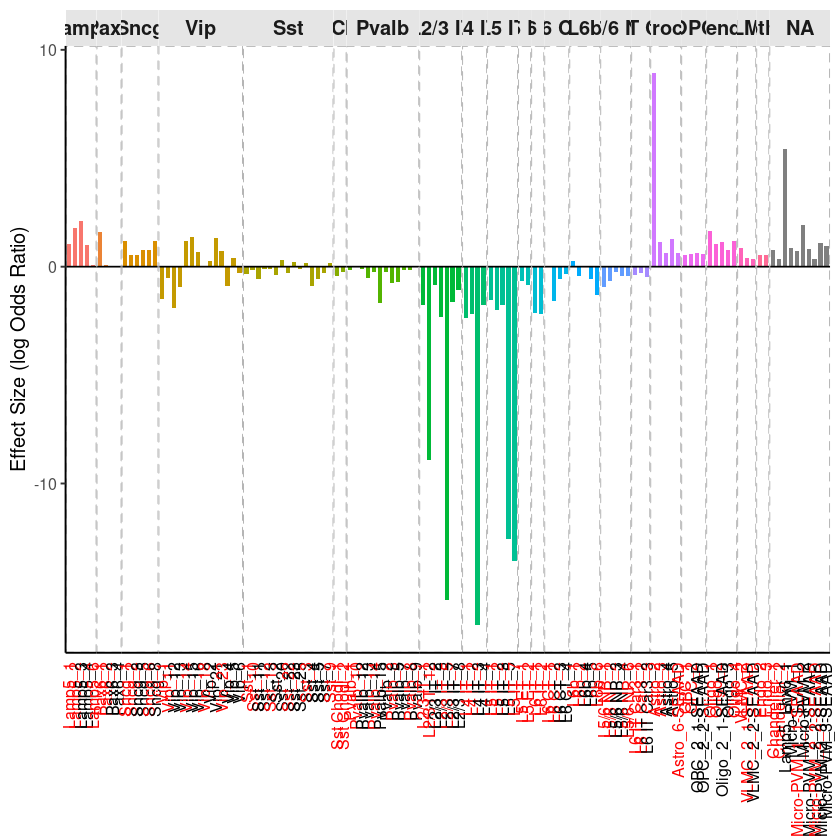

In [9]:
model_results_df <- do.call(rbind, results_list)
rownames(model_results_df) <- NULL

forest_plot_data <- model_results_df %>%
  mutate(
    cell_type_sorted = fct_reorder(Supertype, odds_ratio),
    significance = ifelse(p_value < 0.05, "p < 0.05", "p ≥ 0.05")
  )

supertype_map <- attnData %>%
  select(Supertype, celltype) %>%
  distinct()
  
effect_plot_data <- left_join(forest_plot_data, supertype_map, by = "Supertype") %>%
  mutate(
    log_or = log(odds_ratio),
    log_ci_low = log(ci_low),
    log_ci_high = log(ci_high),
    label_color = ifelse(p_value < 0.05, "red", "black")
  ) %>%
  na.omit()

celltype_order <- c("Lamp5", "Pax6", "Sncg", "Vip", "Sst", "Sst Chodl", "Pvalb", "Pvalb and chandelier", 
                    "L2/3 IT", "L4 IT", "L5 IT", "L5 ET", "L6 IT", "L6 CT", "L6b", "L5/6 NP", "L6 IT Car3",
                    "Astrocyte", "OPC", "Oligodendrocyte", "VLMC", "Microglia and immune", "Endothelial")
existing_levels <- intersect(celltype_order, unique(effect_plot_data$celltype))
effect_plot_data$celltype <- factor(effect_plot_data$celltype, levels = existing_levels)

effect_plot_data <- effect_plot_data %>%
  arrange(celltype, Supertype)

axis_label_colors <- effect_plot_data$label_color

effect_plot_data$Supertype <- factor(effect_plot_data$Supertype, levels = unique(effect_plot_data$Supertype))

final_plot_no_errorbars <- ggplot(
  data = effect_plot_data, 
  aes(x = Supertype, y = log_or, fill = celltype)
) +
  geom_col(width = 0.7) +
  
  geom_hline(yintercept = 0, linetype = "solid", color = "black", linewidth = 0.5) +
  
  facet_grid(. ~ celltype, scales = "free_x", space = "free_x") +
  
  labs(
    y = "Effect Size (log Odds Ratio)",
    x = NULL
  ) +

  theme_classic(base_size = 12) +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, color = axis_label_colors),
    axis.ticks.x = element_blank(),
    legend.position = "none",
    strip.background = element_rect(fill = "grey90", color = NA),
    strip.text = element_text(face = "bold", size = 12),
    panel.spacing.x = unit(0, "lines"),
    panel.border = element_rect(color = "grey70", linetype = "dashed", fill = NA)
  )

ggsave("./Analysis/Figure/Attn_plot/final_plot_no_errorbars.pdf",
       final_plot_no_errorbars, width = 25, height = 8, dpi = 300)

print(final_plot_no_errorbars)